In [19]:
pip install torch Pillow numpy torchvision scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 82.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 79.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 26.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch:1, Batch:    3] loss: 0.121614
[Epoch:1] Test Loss: 3.156430, MAPE: 1.325
[Epoch:2, Batch:    3] loss: 0.106548
[Epoch:2] Test Loss: 3.231478, MAPE: 1.428
[Epoch:3, Batch:    3] loss: 0.095453
[Epoch:3] Test Loss: 3.159270, MAPE: 1.502
[Epoch:4, Batch:    3] loss: 0.085791
[Epoch:4] Test Loss: 3.017971, MAPE: 1.503
[Epoch:5, Batch:    3] loss: 0.075694
[Epoch:5] Test Loss: 2.838358, MAPE: 1.455
[Epoch:6, Batch:    3] loss: 0.067450
[Epoch:6] Test Loss: 2.630516, MAPE: 1.393
[Epoch:7, Batch:    3] loss: 0.064653
[Epoch:7] Test Loss: 2.452356, MAPE: 1.378
[Epoch:8, Batch:    3] loss: 0.054750
[Epoch:8] Test Loss: 2.294843, MAPE: 1.361
[Epoch:9, Batch:    3] loss: 0.053450
[Epoch:9] Test Loss: 2.118084, MAPE: 1.312
[Epoch:10, Batch:    3] loss: 0.044446
[Epoch:10] Test Loss: 1.961378, MAPE: 1.247
[Epoch:11, Batch:    3] loss: 0.045376
[Epoch:11] Test Loss: 1.838300, MAPE: 1.194
[Epoch:12, Batch:    3] loss: 0.039603
[Epoch:12] Test Loss: 1.731163, MAPE: 1.161
[Epoch:13, Batch:    3

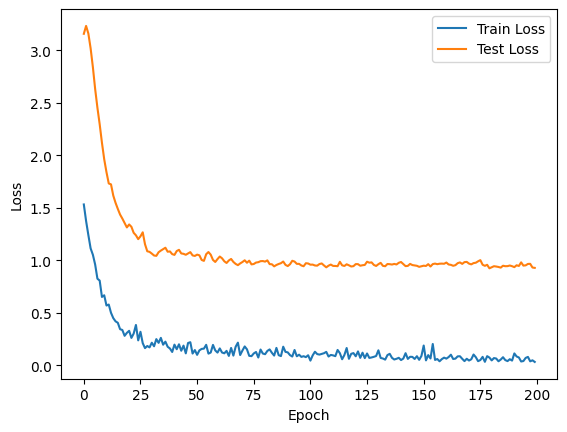

'\nmodel = Model()\n# Input images (assume these are your 2-channel images)\nimage1 = torch.randn(1, 1, 480, 480)\nimage2 = torch.randn(1, 1, 480, 480)\nimage3 = torch.randn(1, 1, 480, 480)\n\n# Pass images through the model\noutput = model(image1, image2,image3)\n\n# Output will have shape [1, 3, 480, 480]\nprint(output.shape)'

In [20]:
#code for 3 input picture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from torchvision.models import resnet50
import matplotlib.pyplot as plt

class ResNet50Encoder(nn.Module):
    def __init__(self, num_channels=1):
        super(ResNet50Encoder, self).__init__()
        
        # Load pre-trained ResNet50 model
        self.resnet50 = resnet50(pretrained=True)
        
        # Replace the first convolution layer to accept a different number of channels
        self.resnet50.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the fully connected layer and the average pooling layer
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])

    def forward(self, x):
        x = self.resnet50(x)
        return x


class ResNetEncoder(nn.Module):
    def __init__(self, num_channels=1):
        super(ResNetEncoder, self).__init__()

        # Define ResNet layers (modify based on your specific ResNet architecture)
        self.resnet = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=20, stride=5, padding=1),
            # Add more ResNet layers here...
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

class FNNReducer(nn.Module):
    def __init__(self, input_size):  # Pass the input size here
        super(FNNReducer, self).__init__()

        # Define fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size, out_features=1024),  # Use input_size
            nn.ReLU(inplace=True),
            nn.Linear(1024, 20 * 20),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        return x
class CNNExpander(nn.Module):
    def __init__(self):
        super(CNNExpander, self).__init__()
        
        # Define convolutional layers
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=6144,  # Input channels match concatenated tensor
            out_channels=1,
            kernel_size=32,
            stride=32,
            padding=0
        )

    def forward(self, x):
        x = self.conv_transpose(x)
        return x
        
class UpsampleNet(nn.Module):
    def __init__(self):
        super(UpsampleNet, self).__init__()
        # Define the first ConvTranspose2d layer
        self.conv_transpose1 = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        # Define the second ConvTranspose2d layer
        self.conv_transpose2 = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        # ... Add more layers as needed ...
        # Define the final ConvTranspose2d layer to reach the desired size
        self.conv_transpose_final = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=24,
            padding=1
        )

    def forward(self, x):
        # Apply the first ConvTranspose2d layer
        x = self.conv_transpose1(x)
        # Apply the second ConvTranspose2d layer
        x = self.conv_transpose2(x)
        # ... Apply additional layers as needed ...
        # Apply the final ConvTranspose2d layer
        x = self.conv_transpose_final(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.resnet_encoder1 = ResNet50Encoder()
        self.resnet_encoder2 = ResNet50Encoder()
        self.resnet_encoder3 = ResNet50Encoder()

        self.cnn_expander = CNNExpander()
        self.UpsampleNet= UpsampleNet()

    def forward(self, x1, x2, x3):
        # ResNet encoding
        x1 = self.resnet_encoder1(x1)
        x2 = self.resnet_encoder2(x2)
        x3 = self.resnet_encoder3(x3)
        

        # Concatenate features
        x = torch.cat((x1, x2,x3), dim=1)  #concat at channal
    
        x = self.cnn_expander(x)

        return x


class ImageDataset(Dataset):
    def __init__(self, input1_folder, input2_folder, input3_folder,output_folder, transform=None):
        self.input1_folder = input1_folder
        self.input2_folder = input2_folder
        self.input3_folder = input3_folder
        self.output_folder = output_folder
       
        # Filter filenames where only the first letter is a number
        self.input1_filenames = sorted([f for f in os.listdir(input1_folder) if f[0].isdigit()])
        self.input2_filenames = sorted([f for f in os.listdir(input2_folder) if f[0].isdigit()])
        self.input3_filenames = sorted([f for f in os.listdir(input3_folder) if f[0].isdigit()])
        self.output_filenames = sorted([f for f in os.listdir(output_folder) if f[0].isdigit()])
        self.transform = transform

    def __len__(self):
        return len(self.input1_filenames)

    def __getitem__(self, idx):
        input1_path = os.path.join(self.input1_folder, self.input1_filenames[idx])
        input2_path = os.path.join(self.input2_folder, self.input2_filenames[idx])
        input3_path = os.path.join(self.input3_folder, self.input3_filenames[idx])
        output_path = os.path.join(self.output_folder, self.output_filenames[idx])

        input1 = Image.open(input1_path).convert('L')
        input2 = Image.open(input2_path).convert('L')
        input3 = Image.open(input3_path).convert('L')
        output = Image.open(output_path).convert('L')

        if self.transform:
            input1 = self.transform(input1)
            input2 = self.transform(input2)
            input3 = self.transform(input3)
            output = self.transform(output)

        return input1, input2,  input3, output

# Define the training function
def train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs):
    # CUDA Usage:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move the model to the GPU

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # Set the model to training mode
        for i, data in enumerate(train_dataloader):
            input1, input2, input3, target = data
            input1 = input1.to(device)
            input2 = input2.to(device)
            input3 = input3.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(input1, input2,input3)

            # Calculate loss
            loss = criterion(output, target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 2:  # Print statistics every 4 batches
                print(f'[Epoch:{epoch + 1}, Batch:{i + 1:5d}] loss: {running_loss / 100:.6f}')
                running_loss = 0.0

        train_losses.append(running_loss / len(train_dataloader))

        # Evaluation phase (after each epoch)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_loss = 0.0
            all_predictions = []
            all_targets = []
            for input1, input2, input3, target in test_dataloader:
                input1 = input1.to(device)
                input2 = input2.to(device)
                input3 = input3.to(device)
                target = target.to(device)

                # Predict using the model
                output = model(input1, input2,input3)

                # Calculate the loss
                loss = criterion(output, target)
                test_loss += loss.item()

                # Store predictions and targets for MAPE calculation
                all_predictions.append(output.cpu().numpy())
                all_targets.append(target.cpu().numpy())

            # Calculate MAPE
            all_predictions = np.concatenate(all_predictions).flatten() # Flatten the array
            all_targets = np.concatenate(all_targets).flatten() # Flatten the array
            mape = mean_absolute_percentage_error(all_targets, all_predictions)

            # Print evaluation results
            test_losses.append(test_loss / len(test_dataloader))
            print(f'[Epoch:{epoch + 1}] Test Loss: {test_loss / len(test_dataloader):.6f}, MAPE: {mape:.3f}')

    # Plot train and test losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Define the training function (same as before)
# ... (code for train)



# Set paths to your input and output folders
input1_folder = '/workspace/AI-Thermal'  # Replace with your actual path
input2_folder = '/workspace/AI-EC/EC-0.5'  # Replace with your actual path
input3_folder = '/workspace/AI-EC/EC-1.5'  # Replace with your actual path
output_folder = '/workspace/AI-CH4 flux' # Replace with your actual path

# Define data transformations (e.g., normalization, resizing)
transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
    
])

# Create the dataset
dataset = ImageDataset(input1_folder, input2_folder, input3_folder,
                       output_folder, transform=transform)

# Split the dataset into train and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=14, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Use batch size 1 for test


# Create the model, optimizer, and loss function
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
#criterion = nn.L1Loss()
criterion = nn.MSELoss()

# Train the model
train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=200)

'''
model = Model()
# Input images (assume these are your 2-channel images)
image1 = torch.randn(1, 1, 480, 480)
image2 = torch.randn(1, 1, 480, 480)
image3 = torch.randn(1, 1, 480, 480)

# Pass images through the model
output = model(image1, image2,image3)

# Output will have shape [1, 3, 480, 480]
print(output.shape)'''

In [8]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [4]:
from torchinfo import summary

# Print a detailed summary of the model
summary(model, input_size=[(1, 1, 480, 480), (1, 1, 480, 480), (1, 1, 480, 480)])

Layer (type:depth-idx)                             Output Shape              Param #
Model                                              [1, 1, 480, 480]          30
├─ResNet50Encoder: 1-1                             [1, 2048, 15, 15]         --
│    └─Sequential: 2-1                             [1, 2048, 15, 15]         --
│    │    └─Conv2d: 3-1                            [1, 64, 240, 240]         3,136
│    │    └─BatchNorm2d: 3-2                       [1, 64, 240, 240]         128
│    │    └─ReLU: 3-3                              [1, 64, 240, 240]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 120, 120]         --
│    │    └─Sequential: 3-5                        [1, 256, 120, 120]        215,808
│    │    └─Sequential: 3-6                        [1, 512, 60, 60]          1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 30, 30]         7,098,368
│    │    └─Sequential: 3-8                        [1, 2048, 15, 15]         14,964,736
├─Re